<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/0102522024_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Import Library**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [43]:
# Load dataset dari folder /content (Colab)
df_exam = pd.read_csv('/content/examination.csv')
df_labs = pd.read_csv('/content/labs.csv')
df_quest = pd.read_csv('/content/questionnaire.csv')

In [44]:
# Dataset pemeriksaan fisik
exam_sel = df_exam[['SEQN', 'BPXSY1', 'BPXDI1', 'BMXWT', 'BMXHT', 'BMXBMI']]

# Dataset laboratorium
labs_sel = df_labs[['SEQN', 'LBXSCH', 'LBXSGL', 'LBXSTR']]

# Dataset questionnaire (bisa ditambah PAQ605/PAQ620 untuk aktivitas atau merokok)
quest_sel = df_quest[['SEQN']]  # kita abaikan dulu, jika belum mau dipakai

In [46]:
exam_sel = df_exam[[
    'SEQN',        # Respondent ID
    'BPXSY1',      # Systolic Blood Pressure
    'BPXDI1',      # Diastolic Blood Pressure
    'BMXWT',       # Weight (kg)
    'BMXHT',       # Height (cm)
    'BMXBMI'       # Body Mass Index (BMI)
]]

# Ubah nama kolom jadi lebih deskriptif
exam_sel = exam_sel.rename(columns={
    'BPXSY1': 'Systolic_BP',
    'BPXDI1': 'Diastolic_BP',
    'BMXWT': 'Weight_kg',
    'BMXHT': 'Height_cm',
    'BMXBMI': 'BMI'
})

In [47]:
labs_sel = df_labs[[
    'SEQN',        # Respondent ID
    'LBXSCH',      # Total Cholesterol (mg/dL)
    'LBXSGL',      # Fasting Glucose (mg/dL)
    'LBXSTR'       # Triglycerides (mg/dL)
]]

# Ubah nama kolom jadi lebih deskriptif
labs_sel = labs_sel.rename(columns={
    'LBXSCH': 'Cholesterol_Total',
    'LBXSGL': 'Glucose_Fasting',
    'LBXSTR': 'Triglycerides'
})

In [48]:
quest_sel = df_quest[['SEQN', 'PAQ605', 'PAQ620']]

# Rename jadi deskriptif
quest_sel = quest_sel.rename(columns={
    'PAQ605': 'Moderate_Activity_Freq',
    'PAQ620': 'Vigorous_Activity_Freq'
})

In [49]:
# Merge dataset pemeriksaan fisik dan laboratorium berdasarkan SEQN
df_health = pd.merge(exam_sel, labs_sel, on='SEQN', how='inner')

# (Opsional) Tambah questionnaire jika ingin menganalisis aktivitas fisik atau kebiasaan lain
# df_health = pd.merge(df_health, quest_sel, on='SEQN', how='inner')

# Cek hasil gabungan
df_health.head()

,SEQN,Systolic_BP,Diastolic_BP,Weight_kg,Height_cm,BMI,Cholesterol_Total,Glucose_Fasting,Triglycerides
0,73557,122.0,72.0,78.3,171.3,26.7,168.0,554.0,140.0
1,73558,156.0,62.0,89.5,176.8,28.6,167.0,219.0,257.0
2,73559,140.0,90.0,88.9,175.3,28.9,127.0,183.0,51.0
3,73560,108.0,38.0,32.2,137.3,17.1,NaN,NaN,NaN
4,73561,136.0,86.0,52.0,162.4,19.7,207.0,104.0,88.0


In [50]:
# Cek jumlah missing values
print(df_health.isnull().sum())

# Drop baris dengan nilai yang hilang
df_clean = df_health.dropna().reset_index(drop=True)

# Lihat jumlah data setelah dibersihkan
print(f'Jumlah data setelah drop NA: {df_clean.shape[0]} observasi')

SEQN                    0
Systolic_BP          2641
Diastolic_BP         2641
Weight_kg              90
Height_cm             746
BMI                   758
Cholesterol_Total    3262
Glucose_Fasting      3260
Triglycerides        3264
dtype: int64
Jumlah data setelah drop NA: 5964 observasi


In [51]:
from sklearn.preprocessing import StandardScaler

# Pisahkan kolom fitur (tanpa SEQN)
X = df_clean.drop(columns=['SEQN'])

# Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

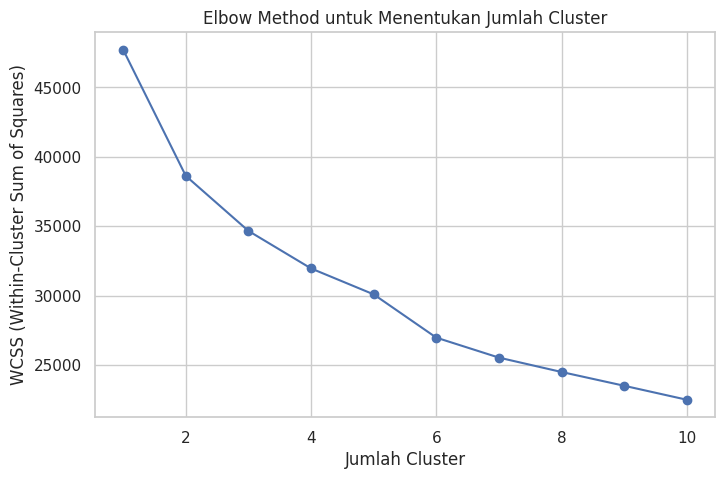

In [52]:
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [53]:
# K-Means dengan k = 3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Tambahkan label cluster ke dataframe bersih
df_clean['Cluster'] = cluster_labels

In [54]:
# Statistik ringkasan rata-rata tiap cluster
cluster_summary = df_clean.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)

                 SEQN  Systolic_BP  Diastolic_BP   Weight_kg   Height_cm  \
Cluster                                                                    
0        78760.200818   109.975456     60.546672   64.993046  165.038349   
1        78685.893039   133.350311     75.820034   74.866723  164.504969   
2        78493.759947   122.909814     70.684350  106.668302  172.734874   

               BMI  Cholesterol_Total  Glucose_Fasting  Triglycerides  
Cluster                                                                
0        23.828449         166.358869        91.336556      97.344738  
1        27.700962         217.357668       105.634409     188.003396  
2        36.007162         176.862732       115.916446     168.777188  


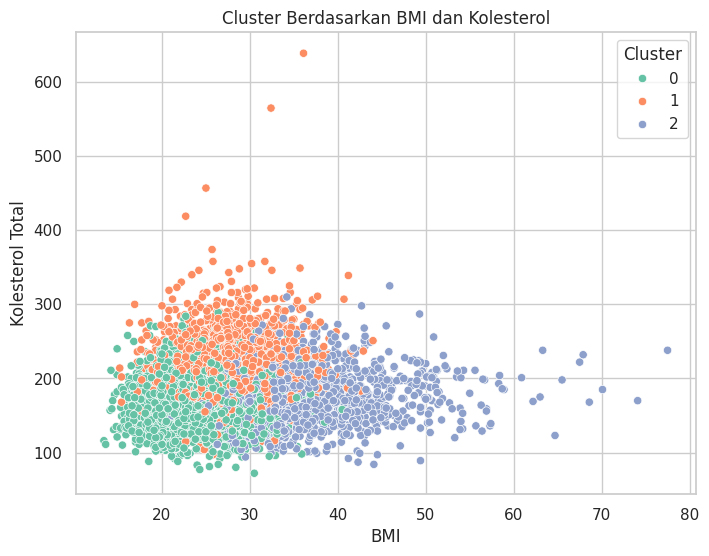

In [55]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='BMI', y='Cholesterol_Total', hue='Cluster', palette='Set2')
plt.title('Cluster Berdasarkan BMI dan Kolesterol')
plt.xlabel('BMI')
plt.ylabel('Kolesterol Total')
plt.grid(True)
plt.show()

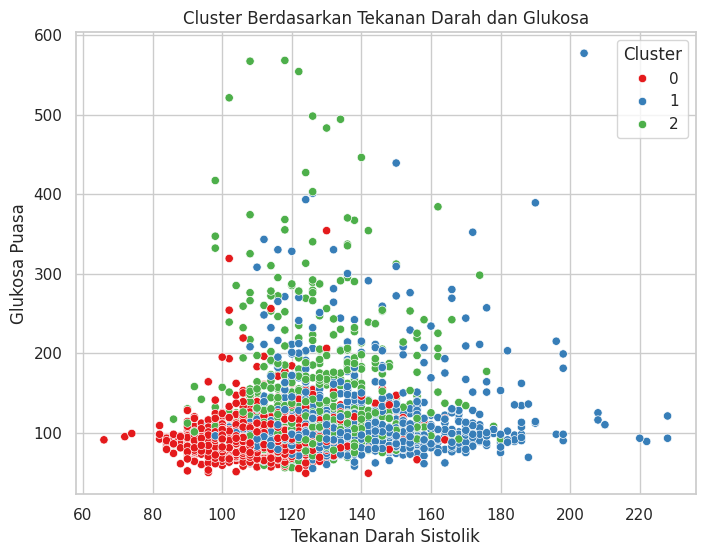

In [56]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='Systolic_BP', y='Glucose_Fasting', hue='Cluster', palette='Set1')
plt.title('Cluster Berdasarkan Tekanan Darah dan Glukosa')
plt.xlabel('Tekanan Darah Sistolik')
plt.ylabel('Glukosa Puasa')
plt.grid(True)
plt.show()

In [57]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, df_clean['Cluster'])
print(f'Silhouette Score untuk k={k}: {score:.3f}')

Silhouette Score untuk k=3: 0.183
